<b><font size="6">Techscape Project</font><a class="anchor"><a id='toc'></a></b><br>

# Import the needed libraries

In [1]:
import pandas as pd
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# 1- filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

# 2- wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# 3- embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
techscape = pd.read_csv('train.csv')
techscape.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,22-Dec-20,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,24-Nov-20,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


In [3]:
#target= techscape['Buy']
##techscape.drop(['Buy','Access_ID'], axis=1, inplace=True)
#techscape.drop('Buy', axis=1, inplace=True)

In [4]:
# Use this cell to check the values of each column 

techscape[techscape.AccountMng_Pages > 8].AccountMng_Pages.value_counts()

9     180
10    127
11     87
12     69
13     47
14     33
15     31
16     19
17     14
18     12
19      5
24      4
22      3
20      2
21      2
23      2
26      1
27      1
Name: AccountMng_Pages, dtype: int64

# Check for missing data

In [5]:
techscape.info()

# There are now missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

# Change the types of the variables

In [6]:
# ID does not make sense to be a int
techscape.Access_ID = techscape.Access_ID.astype('string') 

# Tranform Date into a datetime format
techscape.Date = pd.to_datetime(techscape.Date)

techscape.OS = techscape.OS.astype('string') 


techscape.Country = techscape.Country.astype('string') 


techscape.Type_of_Visitor = techscape.Type_of_Visitor.astype('string') 


techscape.Type_of_Traffic = techscape.Type_of_Traffic.astype('string') 

techscape.Browser = techscape.Browser.astype('string') 


techscape.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Access_ID                   9999 non-null   string        
 1   Date                        9999 non-null   datetime64[ns]
 2   AccountMng_Pages            9999 non-null   int64         
 3   AccountMng_Duration         9999 non-null   float64       
 4   FAQ_Pages                   9999 non-null   int64         
 5   FAQ_Duration                9999 non-null   float64       
 6   Product_Pages               9999 non-null   int64         
 7   Product_Duration            9999 non-null   float64       
 8   GoogleAnalytics_BounceRate  9999 non-null   float64       
 9   GoogleAnalytics_ExitRate    9999 non-null   float64       
 10  GoogleAnalytics_PageValue   9999 non-null   float64       
 11  OS                          9999 non-null   string      

In [7]:
# Separate the metric variables from the non metric ones 
#non_metric_features = ['Access_ID', 'Date',"OS", "Browser", "Country", "Type_of_Traffic", "Type_of_Visitor", 'Buy'] 
#metric_features = techscape.columns.drop(non_metric_features).to_list()

metric_features = techscape.select_dtypes(include=np.number).set_index(techscape.index).columns.to_list()
non_metric_features = techscape.select_dtypes(exclude=np.number).set_index(techscape.index).columns.to_list()

non_metric_features

['Access_ID',
 'Date',
 'OS',
 'Browser',
 'Country',
 'Type_of_Traffic',
 'Type_of_Visitor']

# Check for incoherencies in the data


In [8]:
# Date variable
print(f'Date of the web visit varies from {techscape.Date.min()} and {techscape.Date.max()}, excluding the month of April.')

Date of the web visit varies from 2020-02-01 00:00:00 and 2020-12-31 00:00:00, excluding the month of April.


In [9]:
# Pages and Duration variables

# usually, it doeesn´t make sense that Pages > 0 and Duration = 0. However, there are too many observations like that,
# so, in instead of removing them, we decided to convert (duration = 0, pages=1)  --> (duration = 1, pages=1)

#techscape[(techscape['AccountMng_Pages']==0) & (techscape['AccountMng_Duration']!=0) ] # --> 0
account_index = techscape[(techscape['AccountMng_Pages']>1) & (techscape['AccountMng_Duration']==0) ].index  # --> 3
len(account_index)
techscape.drop(account_index, axis=0, inplace=True)
techscape.loc[techscape['AccountMng_Duration']==0,'AccountMng_Duration'] = 1
techscape

#techscape[(techscape['FAQ_Pages']==0) & (techscape['FAQ_Duration']!=0) ] # --> 0
faq_index = techscape[(techscape['FAQ_Pages']>1) & (techscape['FAQ_Duration']==0) ].index # --> 9
len(faq_index)
techscape.drop(faq_index, axis=0, inplace=True)
techscape.loc[techscape['FAQ_Duration']==0,'FAQ_Duration'] = 1
techscape

#techscape[(techscape['Product_Pages']==0) & (techscape['Product_Duration']!=0) ] # --> 0
product_index = techscape[(techscape['Product_Pages']>1) & (techscape['Product_Duration']==0) ].index # --> 130
len(product_index)
techscape.drop(product_index, axis=0, inplace=True)
techscape.loc[techscape['Product_Duration']==0,'Product_Duration'] = 1
techscape


# Total removed = 3 + 9 + 130 = 142 (1.42%)

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,2020-03-21,0,1.0,0,1.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,2020-05-20,0,1.0,0,1.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,2020-12-04,0,1.0,0,1.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,2020-12-22,0,1.0,0,1.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,2020-11-24,0,1.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,2020-05-08,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,MacOSX,2,Brazil,14,Returner,0
9995,798314158,2020-07-17,6,175.1,0,1.0,3,27.6000,0.0000,0.0111,0.0000,Windows,10,Spain,5,New_Access,0
9996,798339820,2020-03-23,0,1.0,0,1.0,27,644.0000,0.0077,0.0519,0.0000,MacOSX,2,France,3,Returner,0
9997,798371242,2020-05-16,0,1.0,0,1.0,53,715.5000,0.0226,0.0363,0.0000,Windows,2,Italy,3,Returner,0


# Deal with the outliers

In [10]:
# Se descriptive statistics for all the variables
techscape.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Access_ID,9857,9857,488412749,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,9857,305,2020-05-25 00:00:00,118,2020-02-01,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AccountMng_Pages,9857,NaN,NaN,NaN,NaT,NaT,2.35345,3.35272,0,0,1,4,27
AccountMng_Duration,9857,NaN,NaN,NaN,NaT,NaT,82.7298,180.499,1,1,9.5,94,3398.75
FAQ_Pages,9857,NaN,NaN,NaN,NaT,NaT,0.513442,1.28642,0,0,0,0,24
FAQ_Duration,9857,NaN,NaN,NaN,NaT,NaT,35.8572,140.54,1,1,1,1,2549.38
Product_Pages,9857,NaN,NaN,NaN,NaT,NaT,32.0695,44.7341,0,8,18,38,705
Product_Duration,9857,NaN,NaN,NaN,NaT,NaT,1215.84,1967.19,0.5,197,612.625,1483.55,63973.5
GoogleAnalytics_BounceRate,9857,NaN,NaN,NaN,NaT,NaT,0.0200566,0.0448448,0,0,0.0029,0.016,0.2
GoogleAnalytics_ExitRate,9857,NaN,NaN,NaN,NaT,NaT,0.0411221,0.0457887,0,0.0142,0.025,0.0481,0.2


In [11]:
#techscape[['AccountMng_Pages', 'FAQ_Pages', 'Product_Pages']].describe().T
#techscape[['AccountMng_Duration', 'FAQ_Duration', 'Product_Duration']].describe().T
#techscape[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Browser', 'Type_of_Traffic']].describe().T


# AccountMng_Pages appears to have outliers
# Same with FAQ_Pages
# Product_Pages definitely has outliers
# GoogleAnalytics_PageValue appears to have outliers

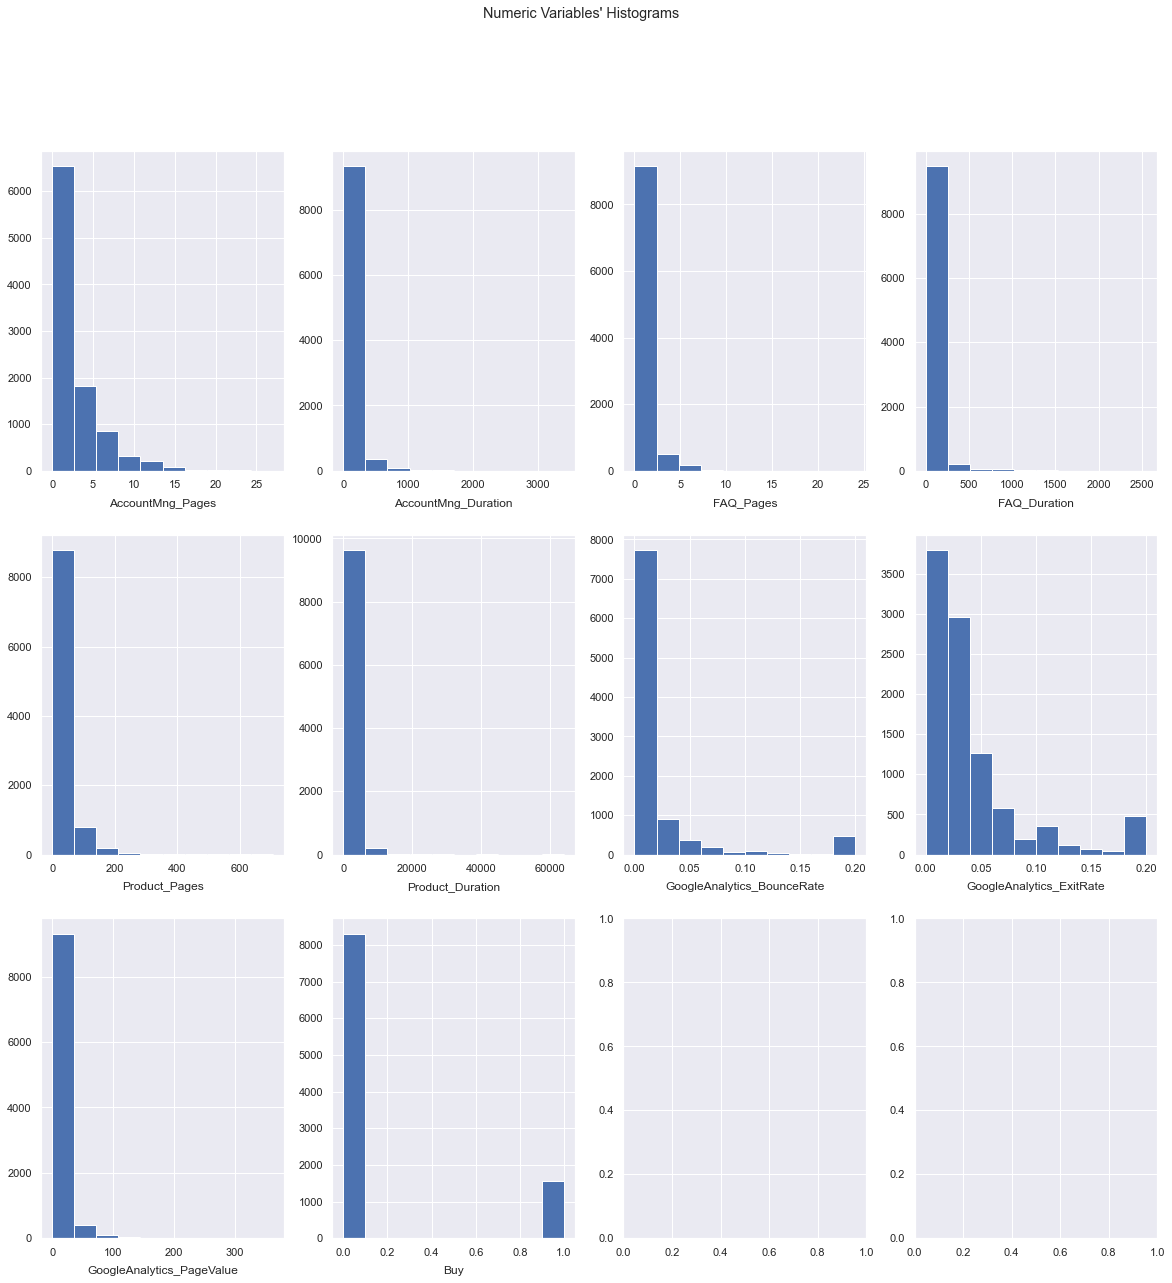

In [12]:
# -----------  Plot the histograms of the numeric variables  -----------

# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, math.ceil(len(metric_features) / 3), figsize=(20,20))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(techscape[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

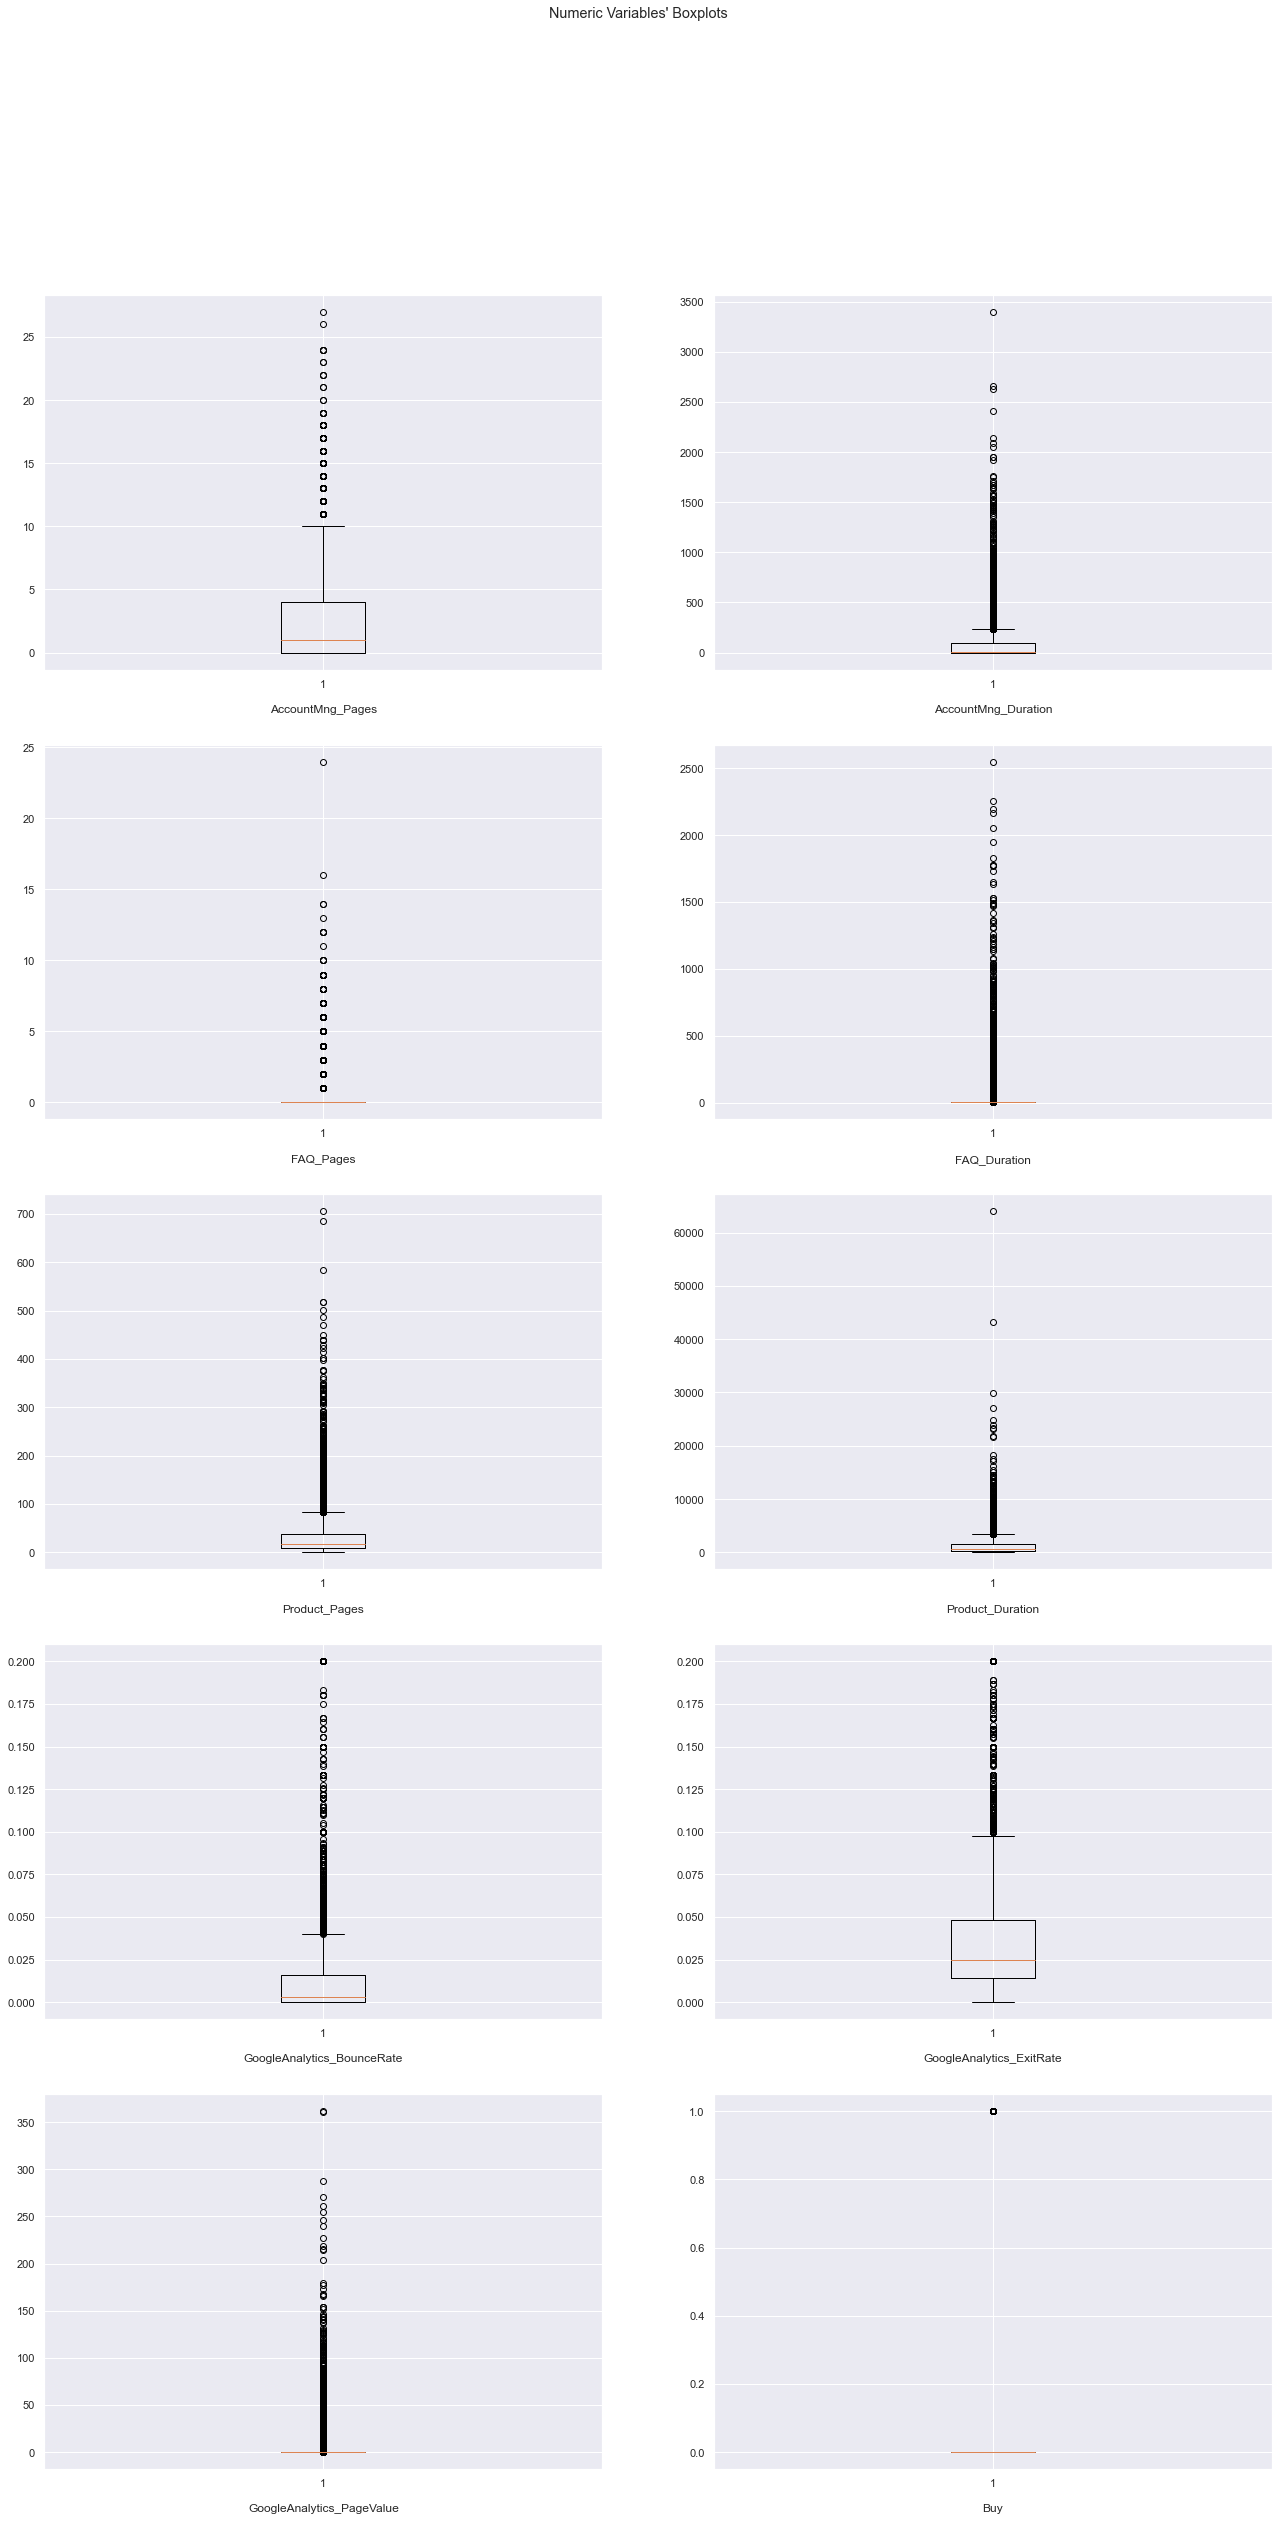

In [13]:
# -----------  Plot the boxplots of the numeric variables  -----------

# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(5, math.ceil(len(metric_features) / 5), figsize=(22, 40))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.boxplot(techscape[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Boxplots"

plt.suptitle(title)

plt.show()

In [33]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters1 = (
    (techscape['GoogleAnalytics_BounceRate']<= 0.1)
    &
    (techscape['GoogleAnalytics_ExitRate']<= 0.1)
    &
    (techscape['GoogleAnalytics_PageValue']<= 80)
    &
    (techscape['AccountMng_Pages']<= 18)  
    &
    (techscape['FAQ_Pages']<=7)
    &
    (techscape['FAQ_Duration']<=700)
    &
    (techscape['FAQ_Duration']<=700)    
)

print(filters1)
techscape_1 = techscape[filters1]

perc_outliers1 = np.round((techscape.shape[0] - techscape_1.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers1}%')

0       True
1       True
2       True
3       True
4       True
        ... 
9994    True
9995    True
9996    True
9997    True
9998    True
Length: 9857, dtype: bool
Percentage of observations removed: 10.54%


In [34]:
techscape[techscape.AccountMng_Pages > 8].AccountMng_Pages.value_counts()

9     180
10    127
11     87
12     69
13     47
14     33
15     31
16     19
17     14
18     12
19      5
24      4
22      3
20      2
21      2
23      2
26      1
27      1
Name: AccountMng_Pages, dtype: int64

In [35]:
#upper_lim

In [44]:
# ------------------  Interquantile method ------------------

#q25 = techscape.quantile(.25)
#q75 = techscape.quantile(.75)
#iqr = (q75 - q25)

techscape_mean, techscape_std = np.mean(techscape), np.std(techscape)

# We can change the number of stds
upper_lim = techscape_mean + 5 * techscape_std   
lower_lim = techscape_mean - 5 * techscape_std

filters2 = []

for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    
    filters2.append(techscape[metric].between(llim, ulim, inclusive=True))
    


filters2 = pd.Series(np.all(filters2, 0))
filters2=filters2.values


techscape_2 = techscape[filters2]

perc_outliers2 = np.round((techscape.shape[0] - techscape_2.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers2}%')

Percentage of observations removed: 3.48%


In [45]:
# Filter 3?? maybe Kmeans

In [46]:
techscape_3 = techscape[(filters1 | filters2)]

perc_outliers3 = np.round((techscape.shape[0] - techscape_3.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of outliers removed: {perc_outliers3}%')

Percentage of outliers removed: 2.0%


# Feature Engineering

In [69]:
# Create new variables

# Create binary variables for operating systems
techscape['Apple'] = techscape['OS'].apply(lambda x: str(1) if x == 'MacOSX' or x == 'iOS' else str(0))  
techscape['Windows'] = techscape['OS'].apply(lambda x: str(1) if x == 'Windows' else str(0))  
techscape['Android'] = techscape['OS'].apply(lambda x: str(1) if x == 'Android' else str(0))



# Create binary variables for countries
techscape['Portugal'] = techscape['Country'].apply(lambda x: str(1) if x == 'Portugal' else str(0)) 
#techscape['European Union'] = techscape['Country'].apply(lambda x: 0 if x == 'United Kingdom' or x == 'Other' or x == 'Brazil' else 1)
techscape['Iberian_Peninsula'] = techscape['Country'].apply(lambda x: str(1) if x == 'Portugal' or x == 'Spain' else str(0))
techscape['Spain'] = techscape['Country'].apply(lambda x: str(1) if x == 'Spain' else str(0))


# Create binary variables for type of visitors
techscape['Returner'] = techscape['Type_of_Visitor'].apply(lambda x: str(1) if x == 'Returner' else str(0)) 
techscape['New_Access'] = techscape['Type_of_Visitor'].apply(lambda x: str(1) if x == 'New_Access' else str(0))


# Create the total duration of the visits and total number of page visits
techscape['Total_Duration'] = techscape['AccountMng_Duration'] + techscape['FAQ_Duration'] + techscape['Product_Duration']
techscape['Total_Pages'] = techscape['AccountMng_Pages'] + techscape['FAQ_Pages'] + techscape['Product_Pages']

techscape.loc[techscape['Total_Pages']==0,'Total_Pages']=1


# Create the proportion of time on each page type
techscape['PropTime_AccountMng'] = techscape['AccountMng_Duration']/techscape['Total_Duration']
techscape['PropTime_FAQ'] = techscape['FAQ_Duration']/techscape['Total_Duration']
techscape['PropTime_Product'] = techscape['Product_Duration']/techscape['Total_Duration']

# Create the proportion of visited pages of each type
techscape['PropPages_AccountMng'] = techscape['AccountMng_Pages']/techscape['Total_Pages']
techscape['PropPages_FAQ'] = techscape['FAQ_Pages']/techscape['Total_Pages']
techscape['PropPages_Product'] = techscape['Product_Pages']/techscape['Total_Pages']

# Create the average time spent per page
techscape['AvgTimePerPage'] = techscape['Total_Duration'].div(techscape['Total_Pages'].values)
### avg time per type of page?



# Create the month of the visit
techscape['Month'] = techscape['Date'].dt.month


# Create variable Covid
techscape['Covid']=techscape['Month'].apply(lambda x: str(1) if x>3 else str(0))

techscape





,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,...,Total_Pages,PropTime_AccountMng,PropTime_FAQ,PropTime_Product,PropPages_AccountMng,PropPages_FAQ,PropPages_Product,AvgTimePerPage,Month,Covid
0,102863333,2020-03-21,0,1.0,0,1.0,3,64.0000,0.0000,0.0667,...,3,0.015152,0.015152,0.969697,0.000000,0.000000,1.000000,22.000000,3,0
1,103117814,2020-05-20,0,1.0,0,1.0,23,684.5000,0.0217,0.0449,...,23,0.001457,0.001457,0.997087,0.000000,0.000000,1.000000,29.847826,5,1
2,103201891,2020-12-04,0,1.0,0,1.0,8,95.0000,0.0250,0.0583,...,8,0.010309,0.010309,0.979381,0.000000,0.000000,1.000000,12.125000,12,1
3,103226087,2020-12-22,0,1.0,0,1.0,9,608.7500,0.0000,0.0250,...,9,0.001637,0.001637,0.996725,0.000000,0.000000,1.000000,67.861111,12,1
4,103234445,2020-11-24,0,1.0,2,386.0,36,1609.9397,0.0000,0.0093,...,38,0.000501,0.193296,0.806203,0.000000,0.052632,0.947368,52.551045,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,2020-05-08,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,...,28,0.120947,0.042217,0.836836,0.107143,0.071429,0.821429,46.950893,5,1
9995,798314158,2020-07-17,6,175.1,0,1.0,3,27.6000,0.0000,0.0111,...,9,0.859597,0.004909,0.135493,0.666667,0.000000,0.333333,22.633333,7,1
9996,798339820,2020-03-23,0,1.0,0,1.0,27,644.0000,0.0077,0.0519,...,27,0.001548,0.001548,0.996904,0.000000,0.000000,1.000000,23.925926,3,0
9997,798371242,2020-05-16,0,1.0,0,1.0,53,715.5000,0.0226,0.0363,...,53,0.001394,0.001394,0.997213,0.000000,0.000000,1.000000,13.537736,5,1


In [70]:
techscape.drop('OS', axis=1, inplace=True)
techscape.drop('Country', axis=1, inplace=True)
techscape.drop('Type_of_Visitor', axis=1, inplace=True)
techscape.drop('Date', axis=1, inplace=True)
techscape.drop('Access_ID', axis=1, inplace=True)

# Data Partition



In [71]:
techscape.head(3)

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser,...,Total_Pages,PropTime_AccountMng,PropTime_FAQ,PropTime_Product,PropPages_AccountMng,PropPages_FAQ,PropPages_Product,AvgTimePerPage,Month,Covid
0,0,1.0,0,1.0,3,64.0,0.0000,0.0667,0.0,2,...,3,0.015152,0.015152,0.969697,0.0,0.0,1.0,22.000000,3,0
1,0,1.0,0,1.0,23,684.5,0.0217,0.0449,0.0,2,...,23,0.001457,0.001457,0.997087,0.0,0.0,1.0,29.847826,5,1
2,0,1.0,0,1.0,8,95.0,0.0250,0.0583,0.0,4,...,8,0.010309,0.010309,0.979381,0.0,0.0,1.0,12.125000,12,1


In [72]:
# -------------- DATA PARTITION --------------

# Define data as all the independent variables
data = techscape.drop(['Buy'], axis=1)
# Define target as the dependent variable
target = techscape['Buy']

# -----------------------

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, target, train_size=0.75, stratify = target, random_state=5)
# Train 0.75 || Valid 0.25
# Stratify so we have the same values in target in the train and val datasets

# -----------------------

X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
# DO IT for validation
X_val_metric = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_non_metric = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

In [73]:
# -------------- SCALLING --------------

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train_metric)
X_train_metric_scaled = scaler.transform(X_train_metric) # this will return an array

## Convert the array to a pandas dataframe
X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train.index)
display(X_train_metric_scaled.head(3))

X_val_metric_scaled = scaler.transform(X_val_metric)
X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val_metric.columns).set_index(X_val.index)
display(X_val_metric_scaled.head(3))


,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Total_Duration,Total_Pages,PropTime_AccountMng,PropTime_FAQ,PropTime_Product,PropPages_AccountMng,PropPages_FAQ,PropPages_Product,AvgTimePerPage,Month
4128,0.000000,0.000000,0.000000,0.000000,0.015603,0.010322,0.000,0.0000,0.093532,0.009444,0.013423,0.001429,0.001556,0.997155,0.000000,0.000000,1.000000,0.049908,0.4
9610,0.148148,0.017659,0.000000,0.000000,0.165957,0.024532,0.017,0.0595,0.138086,0.023304,0.161074,0.037437,0.000596,0.962108,0.033058,0.000000,0.966942,0.010846,0.3
5719,0.222222,0.036348,0.208333,0.051732,0.063830,0.014078,0.020,0.0505,0.000000,0.016532,0.073826,0.107796,0.122805,0.777587,0.107143,0.089286,0.803571,0.016860,0.3


,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Total_Duration,Total_Pages,PropTime_AccountMng,PropTime_FAQ,PropTime_Product,PropPages_AccountMng,PropPages_FAQ,PropPages_Product,AvgTimePerPage,Month
2967,0.148148,0.026076,0.083333,0.004316,0.018440,0.002845,0.0,0.0740,0.000000,0.004028,0.024161,0.316493,0.045198,0.641832,0.210526,0.105263,0.684211,0.012071,0.7
9346,0.000000,0.000000,0.000000,0.000000,0.009929,0.009030,0.0,0.1665,0.161675,0.008262,0.008054,0.001645,0.001787,0.996724,0.000000,0.000000,1.000000,0.068810,0.3
5314,0.259259,0.189390,0.083333,0.064943,0.043972,0.025466,0.0,0.1305,0.000000,0.034871,0.052349,0.264986,0.073037,0.667214,0.175000,0.050000,0.775000,0.050544,1.0


In [74]:
# 1 - Filter methods

In [75]:
# Check if any of the variables is univariate

X_train_metric_scaled.var()

# There isn't univariate variables
# Keep: all
# Remove: none

AccountMng_Pages              0.015500
AccountMng_Duration           0.002856
FAQ_Pages                     0.003053
FAQ_Duration                  0.002811
Product_Pages                 0.003960
Product_Duration              0.000986
GoogleAnalytics_BounceRate    0.050431
GoogleAnalytics_ExitRate      0.052246
GoogleAnalytics_PageValue     0.002771
Total_Duration                0.000942
Total_Pages                   0.003889
PropTime_AccountMng           0.024023
PropTime_FAQ                  0.011072
PropTime_Product              0.041470
PropPages_AccountMng          0.015847
PropPages_FAQ                 0.002473
PropPages_Product             0.019957
AvgTimePerPage                0.001104
Month                         0.116142
dtype: float64

# Feature Selection

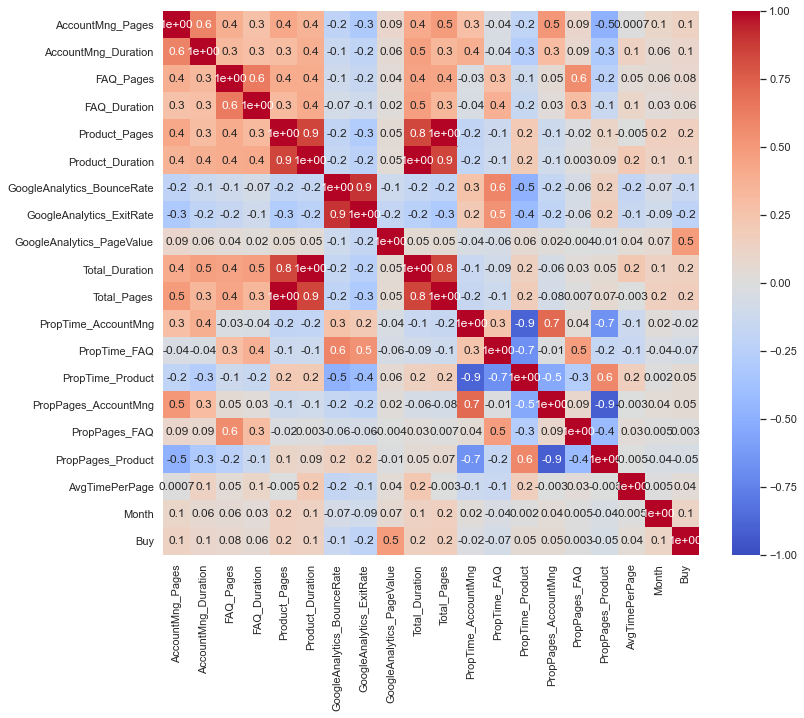

In [76]:
# Check correlations (numerical data)

all_train_metric = X_train_metric_scaled.join(y_train)
all_train_metric.head()

corr = all_train_metric.corr(method = 'pearson')  # or spearman

def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, vmin=-1, vmax=1, annot = True, cmap ="coolwarm" , fmt='.1')

    plt.show()
    
cor_heatmap(corr)    

In [77]:
# Better visualization of correlation values (numerical data)

corr.style.applymap(lambda x: 'background-color : green' if x > 0.6 else ('background-color : red' if x < -0.6 else ''))

# Correlated variables: AccountMng_Duration-AccountMng_Pages, FAQ_Duration-FAQ_Pages, FAQ_Duartion-PropTime_FAQ,
#                       Product_Duration-Product_Pages, Product_Pages-Total_Duration, Product_Pages-Total_Pages,
#                       Product_Duration-Total_Duration, Product_Duration-Total_Pages, PropTime_FAQ-PropPages_FAQ
#                       GoogleAnalytics_BounceRate-GoogleAnalytics_ExitRate, Apple-Windows, Portugal-Iberian_Peninsula,
#                       Returner-New_Access, Total_Duration-Total_Pages, PropTime_AccountMng-PropTime_Product, 
#                       PropTime_AccountMng-PropPages_AccountMng, PropTime_AccountMng-PropTime_Product

# None of the indepent variables is highly correlated with the dependent one but there are a lot of highly correlated variables (|p|>=0.85)
# With other method, we should check for the relevancy the following pairs to choose one of them:
# - Product_Pages and Product_Duartion
# - GoogleAnalytics_BounceRate and GoogleAnalytics_ExitRate
# - Returner and New_Access
# - Total_Pages and Product_Pages
# - Total_Pages and Product_Duration
# - PropTime_Product and PropTime_AccountMng
# - PropPages_Product and PropPages_AccountMng
# - Total_Duration and Product_Duration

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Total_Duration,Total_Pages,PropTime_AccountMng,PropTime_FAQ,PropTime_Product,PropPages_AccountMng,PropPages_FAQ,PropPages_Product,AvgTimePerPage,Month,Buy
AccountMng_Pages,1.000000,0.605810,0.386527,0.269068,0.424524,0.366478,-0.208899,-0.307088,0.094210,0.411183,0.488750,0.288135,-0.037714,-0.200691,0.510287,0.094769,-0.484747,0.000714,0.103059,0.141922
AccountMng_Duration,0.605810,1.000000,0.321385,0.281924,0.303606,0.389315,-0.133905,-0.197052,0.061975,0.466722,0.342910,0.384970,-0.040854,-0.272746,0.311053,0.085869,-0.305264,0.145615,0.064902,0.097141
FAQ_Pages,0.386527,0.321385,1.000000,0.639698,0.401818,0.405893,-0.106024,-0.158196,0.037850,0.447339,0.440196,-0.025431,0.286902,-0.119313,0.048484,0.555828,-0.236985,0.046335,0.060001,0.082321
FAQ_Duration,0.269068,0.281924,0.639698,1.000000,0.318054,0.410247,-0.070825,-0.105329,0.016232,0.470763,0.341431,-0.040844,0.378412,-0.151821,0.030809,0.303016,-0.132931,0.103429,0.034495,0.061652
Product_Pages,0.424524,0.303606,0.401818,0.318054,1.000000,0.851291,-0.190786,-0.285356,0.048744,0.842417,0.997063,-0.190969,-0.127522,0.206711,-0.119864,-0.016801,0.116173,-0.004733,0.161831,0.162747
Product_Duration,0.366478,0.389315,0.405893,0.410247,0.851291,1.000000,-0.164172,-0.233917,0.045116,0.994648,0.850980,-0.186799,-0.114365,0.197186,-0.095675,0.003116,0.087053,0.213998,0.137310,0.147847
GoogleAnalytics_BounceRate,-0.208899,-0.133905,-0.106024,-0.070825,-0.190786,-0.164172,1.000000,0.901726,-0.112887,-0.169434,-0.200262,0.263749,0.594548,-0.487680,-0.170090,-0.056914,0.152400,-0.176857,-0.065027,-0.142773
GoogleAnalytics_ExitRate,-0.307088,-0.197052,-0.158196,-0.105329,-0.285356,-0.233917,0.901726,1.000000,-0.173785,-0.242223,-0.299167,0.211037,0.536608,-0.419634,-0.196088,-0.060602,0.179411,-0.149111,-0.094722,-0.206976
GoogleAnalytics_PageValue,0.094210,0.061975,0.037850,0.016232,0.048744,0.045116,-0.112887,-0.173785,1.000000,0.048489,0.054437,-0.042215,-0.061666,0.061871,0.018510,-0.004116,-0.013502,0.043327,0.066681,0.489565
Total_Duration,0.411183,0.466722,0.447339,0.470763,0.842417,0.994648,-0.169434,-0.242223,0.048489,1.000000,0.846924,-0.144815,-0.086660,0.151901,-0.061278,0.029262,0.047268,0.219109,0.136168,0.150468


In [78]:
# Chi-Square for categorical data

X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)
    
    
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)
    
# Keep: Date, OS, Type_of_Visitor
# Remove: Access_ID, Country

Browser is NOT an important predictor. (Discard Browser from model)
Type_of_Traffic is IMPORTANT for Prediction
Apple is IMPORTANT for Prediction
Windows is IMPORTANT for Prediction
Android is NOT an important predictor. (Discard Android from model)
Portugal is NOT an important predictor. (Discard Portugal from model)
Iberian_Peninsula is NOT an important predictor. (Discard Iberian_Peninsula from model)
Spain is NOT an important predictor. (Discard Spain from model)
Returner is IMPORTANT for Prediction
New_Access is IMPORTANT for Prediction
Covid is IMPORTANT for Prediction


In [79]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7392 entries, 4128 to 4863
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Browser            7392 non-null   string
 1   Type_of_Traffic    7392 non-null   string
 2   Apple              7392 non-null   object
 3   Windows            7392 non-null   object
 4   Android            7392 non-null   object
 5   Portugal           7392 non-null   object
 6   Iberian_Peninsula  7392 non-null   object
 7   Spain              7392 non-null   object
 8   Returner           7392 non-null   object
 9   New_Access         7392 non-null   object
 10  Covid              7392 non-null   object
dtypes: object(9), string(2)
memory usage: 693.0+ KB


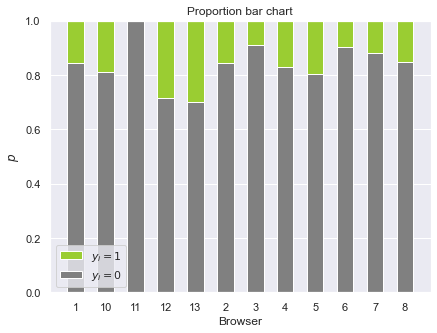

In [80]:
# Visualize weight of dependent variable in categorical data

# first join all the training data
all_train = X_train.join(y_train)


def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    #plt.subplot(4,2)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    #plt.xticks()
    plt.show()
    
bar_charts_categorical(all_train, "Browser", "Buy")

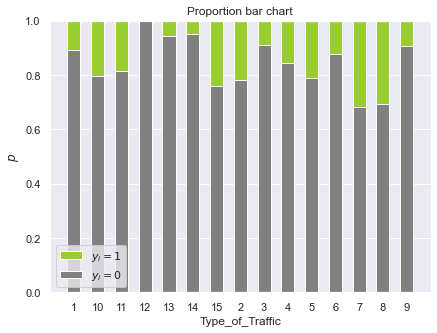

In [81]:
bar_charts_categorical(all_train, "Type_of_Traffic", "Buy")

In [82]:
bar_charts_categorical(all_train, "OS", "Buy")

KeyError: 'OS'

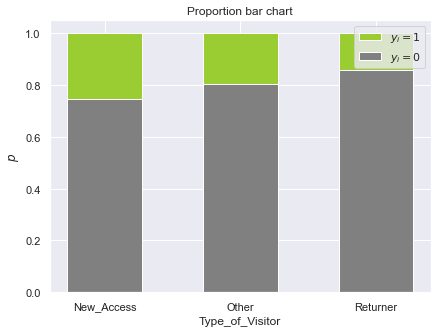

In [61]:
bar_charts_categorical(all_train, "Type_of_Visitor", "Buy")

In [62]:
X_train_metric_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7392 entries, 4128 to 4863
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AccountMng_Pages            7392 non-null   float64
 1   AccountMng_Duration         7392 non-null   float64
 2   FAQ_Pages                   7392 non-null   float64
 3   FAQ_Duration                7392 non-null   float64
 4   Product_Pages               7392 non-null   float64
 5   Product_Duration            7392 non-null   float64
 6   GoogleAnalytics_BounceRate  7392 non-null   float64
 7   GoogleAnalytics_ExitRate    7392 non-null   float64
 8   GoogleAnalytics_PageValue   7392 non-null   float64
dtypes: float64(9)
memory usage: 897.5 KB


In [83]:
# Check the best number of features to retain

nof_list=np.arange(1,15)            
high_score=0

# Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_metric_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_metric_scaled)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_val_rfe,y_val)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

# Quais as 2 features?

Optimum number of features: 2
Score with 2 features: 0.869777


In [84]:
# ------------ 2- Wrapper methods (RFE) ------------

model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 3)
X_rfe = rfe.fit_transform(X = X_train_metric_scaled, y = y_train)

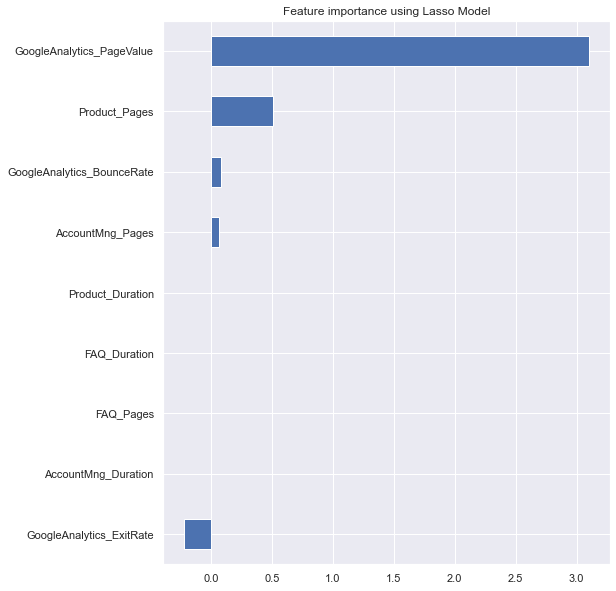

In [66]:
# ------------ 3- Embedded methods (Lasso Regression) ------------

def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
    
reg = LassoCV()
reg.fit(X_train_metric_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_metric_scaled.columns)
coef.sort_values()

plot_importance(coef,'Lasso')

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

<hr>

### Numerical Data

| Predictor | Spearman | RFE | Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |--- |
| AccountMng_Pages | Discard | Keep | Keep ?| Include in the model |
| AccountMng_Duration | Discard | Keep | Keep | Include in the model |
| FAQ_Pages | Discard | Discard | Keep | Try with and without |
| FAQ_Duration | Discard | Discard | Discard |  Discard |
| Product_Pages | Discard | Discard | Discard |  Discard |
| Product_Duration | Discard | Keep | Keep | Include in the model |
| GoogleAnalytics_BounceRate | Discard | Discard | Keep ? | Discard |
| GoogleAnalytics_ExitRate | Discard | Keep | Keep ?| Include in the model |
| GoogleAnalytics_PageValue | Discard | Keep | Keep | Include in the model |
| Browser | Discard | Discard | Discard |  Discard |
| Type_of_Traffic | Discard | Keep | Keep | Include in the model |
| Apple | Discard | Keep | Keep ?| Include in the model |
| Windows | Discard | Keep | Keep | Include in the model |
| Android | Discard | Discard | Keep | Try with and without |
| Portugal | Discard | Discard | Discard |  Discard |
| Iberian_Peninsula | Discard | Discard | Discard |  Discard |
| Returner | Discard | Keep | Keep | Include in the model |
| New_Access | Discard | Discard | Keep ? | Discard |
| Total_Duration | Discard | Keep | Keep ?| Include in the model 
| Total_Pages | Discard | Discard | Keep | Try with and without |
| PropTime_AccountMng | Discard | Discard | Discard |  Discard |
| PropTime_FAQ | Discard | Discard | Discard |  Discard |
| PropTime_Product | Discard | Keep | Keep | Include in the model |
| PropPages_AccountMng | Discard | Discard | Keep ? | Discard |
| PropPages_FAQ | Discard | Keep | Keep ?| Include in the model |
| PropPages_Product | Discard | Keep | Keep | Include in the model |
| AvgTimePerPage | Discard | Discard | Keep | Try with and without |
| Month | Discard | Discard | Discard |  Discard | 


<hr>


### Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| OS | Keep |  
| Country | Discard | 
| Type_of_Visitor | Keep |

<hr>

In [ ]:
# Model Evaluation and selection: (Lab class model selection)

# train/test/split:
# Training dataset, with 60% of the data, that will allow me to build the model;
# Validation dataset, with 20% of the data, that will allow me to fine tune the model and check some problems like overfitting;
# Test dataset, with 20% of the data, that will allow me to evaluate the performance of the final model.


# train/test/split vs K fold vs repeated k fold vs leave one out vs Stratified k-fold
# Ways of splitting the train/val/test datasets


# Model Selection
# Logistic vs Decision Trees vs Naive Bayes vs KNN

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# ????????????
#X_train['Date'] = pd.to_numeric(pd.to_datetime(X_train['Date']))
#
#log_model = LogisticRegression()
#log_model.fit(X_train, y_train)
#y_pred = log_model.predict(X_val)
#pred_prob = log_model.predict_proba(X_test)


In [ ]:
import sys
#!{sys.executable} -m pip install regressors
from regressors import stats

xlabels = X_train.columns
xlabels
print(log_model.coef_)
print(log_model.intercept_)

# Regression
stats.summary(clf = log_model, X = X_train, y = y_train)#, xlabels = xlabels)

In [ ]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

# Performance Measures

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [ ]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [ ]:
labels_train = log_model.predict(X_train)
labels_val = log_model.predict(X_val)

In [ ]:
metrics(y_train=y_train, pred_train=labels_train , y_val=y_val, pred_val=labels_val)

# Deployment

In [ ]:
test = pd.read_csv('test.csv')
test.head()

In [ ]:
test['Buy'] = final_model.predict(test)

test['Buy'].value_counts()